# Simulation of an anisotropic Heisenberg Chain in an External Magnetic Field using a Suzuki-Trotter Scheme

I set out to simulate a Heisneberg chain with nearest neighbour interaction, in the presence of an external magnetic field. The Hamiltonian of the system is

$$\hat{H} = \sum_{i = 0}^{N-2} \sum_{k = 1}^{3} \bigg( J_k \hat{\sigma}^{(i)}_k \otimes \hat{\sigma}^{(i+1)}_k+ h_k \hat{\sigma}^{(i)}_k \bigg)$$

The simulation is based upon the Hamiltonian partition

$$\hat{H} = \sum_{i = 0}^{N-2} \hat{H}_{i,i+1} + \sum_{l = 1}^{3} \hat{H}_l$$

With the definitions

$$\hat{H}_{i,j} = \sum_{k = 1}^{3} J_k \hat{\sigma}^{(i)}_k \otimes \hat{\sigma}^{(j)}_k$$
$$\hat{H}_l = h_l \sum_{i = 0}^{N-1} \hat{\sigma}_l^{(i)}$$

For $l = 1,2,3$. In this notebook I propose a Trotterization scheme and try to simulate a small chain with it.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram, plot_bloch_multivector
backend = Aer.get_backend('qasm_simulator')

## Evolution under Hamiltonians $\hat{H}_{l}$

It is immediate that evolution under each of these Hamiltonias may be performed by simple rotations on x, y and z axes. The x rotation is particularly interesting, since it can be *squished* inside time evolution under Hamiltonian $\hat{H}_{i,j}$. This beacuse an x-rotation on the target qubit of a CNOT commuts with that gate.

**Note:** A more detailed discussion on this issue may be found in the file ```log/SimulationAlgorithms.pdf```

In the following cells I set out to

* Present the scheme for simulation under external field with y-z components
* Build a custom instruction that evolves under this sub-Hamiltonian

**Note:** I parametrize this instruction using $\alpha_l = h_l \Delta t /2$.

$$\alpha_1 = h_l \Delta t /2$$
$$\alpha_2 = h_l \Delta t /2$$
$$\alpha_3 = h_l \Delta t$$

In [2]:
alpha1, alpha2, alpha3 = Parameter('α_1'), Parameter('α_2'), Parameter('α_3') 
def U_23(spinChain):
    ## Create a sample quantum circuit
    qc_U23 = QuantumCircuit(spinChain)
    ## Perform y-z rotations
    for spin in spinChain:
        ## For left of Suzuki-Trotter
        qc_U23.ry(alpha2,spin)
        ## For middle of Suzuki-Trotter
        qc_U23.rz(alpha3,spin)
        ## For inverted left (right) of Suzuki-Trotter
        qc_U23.ry(alpha2,spin)
    ## Return instruction
    return qc_U23.to_instruction()

I test the functioning of the instruction with a sample spin chain

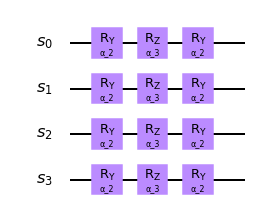

In [3]:
## Create demo spin chain
DemoSpinChain = QuantumRegister(4,name='s')
## Create quantum circuit
qc_U23 = QuantumCircuit(DemoSpinChain)
## Append instruction and make it explicit
qc_U23.append(U_23(DemoSpinChain),DemoSpinChain)
qc_U23 = qc_U23.decompose()
## Draw sample circuit
qc_U23.draw(output='mpl')

## Evolution under Hamiltonian $\hat{H}_{i,j}$

I have already proposed a simulation scheme for exact simulation that used an ancilla bit. However, I believe that no ancilla bit is needed. I updated the algorithm so that only **5 single-qubit rotations** and **5 CNOT gates** are needed. In the next cells

* The subroutine for simulation under this Hamiltonian is explicitly presented
* Include a prescription for taking into account an x field interaction
* A custom instruction that evolves under this Hamiltonian is defined

### Subroutine for computing unitary $\hat{U}_{i,j} = \exp(-\mathrm{i}\hat{H}_{i,j}t)$

Like before, I push the phases by transforming from Bell basis to computational basis. In this basis, evolution corresponds to single-qubit z-rotations, with angles that depend on the exchange integrals and timesteps. The subroutine is parametrized by

$$\theta_1 = J_1 \Delta t / 2$$
$$\theta_2 = J_2 \Delta t / 2$$
$$\theta_3 = J_3 \Delta t / 2$$

**NOTE:** For simplicity, I define a parametrized circuit that uses the generic label $\theta$ for the parameters of this subroutine.

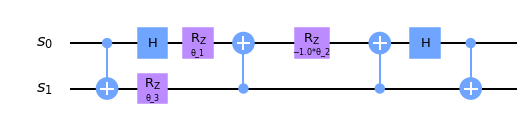

In [4]:
## Definition of parameters for time simulation
theta_1, theta_2, theta_3 = Parameter('θ_1'), Parameter('θ_2'), Parameter('θ_3')
## Initialization of quantum register
spinPair = QuantumRegister(2,name = 's')
## Initialization of quantum circuit
qc_Uij = QuantumCircuit(spinPair)
## Convert to Computational Basis
qc_Uij.cx(spinPair[0],spinPair[1])
qc_Uij.h(spinPair[0])
## Compute J_3 phase
qc_Uij.rz(theta_3,spinPair[1])
## Compute J_1 phase
qc_Uij.rz(theta_1,spinPair[0])
## Compute J_2 phase
qc_Uij.cx(spinPair[1],spinPair[0])
qc_Uij.rz(-theta_2,spinPair[0])
qc_Uij.cx(spinPair[1],spinPair[0])
## Return to computational basis
qc_Uij.h(spinPair[0])
qc_Uij.cx(spinPair[0],spinPair[1])
## Draw quantum circuit
qc_Uij.draw(output='mpl')

### Inclusion of $\hat{H}_1$

From the circuit above, it is clear that there are two *pockets* for performing the x-rotations required to evolve a spin in the presence of a x-orinted magnetic field. The pockets locate right below the Hadamard gates. The rotation is to be located on the right side when the evolution is performed before the z-oeirnted magnetic field evolution. It is located on the left, when it happens after. *This jargon is clearer if the reader sees the log*.

This means that I have to perform 2 types of instructions: left and right evolution

In [5]:
## Left unitary evolution : After z-mag. field evolution
def UijLeft():
    ## Initialization of quantum register
    spinPair = QuantumRegister(2,name = 's')
    ## Initialization of quantum circuit
    qc_Uij = QuantumCircuit(spinPair)
    ## Convert to Computational Basis
    qc_Uij.cx(spinPair[0],spinPair[1])
    qc_Uij.h(spinPair[0])
    ## Include x-magnetic field evolution for s_1
    qc_Uij.rx(alpha1,spinPair[1])
    ## Compute J_3 phase
    qc_Uij.rz(theta_3,spinPair[1])
    ## Compute J_1 phase
    qc_Uij.rz(theta_1,spinPair[0])
    ## Compute J_2 phase
    qc_Uij.cx(spinPair[1],spinPair[0])
    qc_Uij.rz(-theta_2,spinPair[0])
    qc_Uij.cx(spinPair[1],spinPair[0])
    ## Return to computational basis
    qc_Uij.h(spinPair[0])
    qc_Uij.cx(spinPair[0],spinPair[1])
    ## Return Instruction
    return qc_Uij.to_instruction()
## Right unitary evolution : Before z-mag. field evolution
def UijRight():
    ## Initialization of quantum register
    spinPair = QuantumRegister(2,name = 's')
    ## Initialization of quantum circuit
    qc_Uij = QuantumCircuit(spinPair)
    ## Convert to Computational Basis
    qc_Uij.cx(spinPair[0],spinPair[1])
    qc_Uij.h(spinPair[0])
    ## Compute J_3 phase
    qc_Uij.rz(theta_3,spinPair[1])
    ## Compute J_1 phase
    qc_Uij.rz(theta_1,spinPair[0])
    ## Compute J_2 phase
    qc_Uij.cx(spinPair[1],spinPair[0])
    qc_Uij.rz(-theta_2,spinPair[0])
    qc_Uij.cx(spinPair[1],spinPair[0])
    ## Return to computational basis
    qc_Uij.h(spinPair[0])
    ## Include x-magnetic field evolution for s_1
    qc_Uij.rx(alpha1,spinPair[1])
    qc_Uij.cx(spinPair[0],spinPair[1])
    ## Return Instruction
    return qc_Uij.to_instruction()

### Custom gate definition

I would like to convert this circuit to a instruction, and then use ```decompose```, to see the whole picture

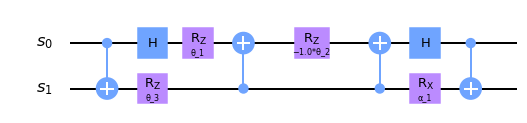

In [6]:
## Create demo spin chain
DemoSpinChain = QuantumRegister(2,name='s')
## Create quantum circuit
qc_Uij = QuantumCircuit(DemoSpinChain)
## Append instruction and make it explicit
qc_Uij.append(UijRight(),DemoSpinChain)
qc_Uij = qc_Uij.decompose()
## Draw sample circuit
qc_Uij.draw(output='mpl')

## Simulation Scheme

Here I will not reproduce the whole scheme, but only implement it. The principle is to evolve spin interaction by even pairs (including x-mag. field interaction for even spin), then for odd pairs, and finaly, for the y-z magnetic field. I implement the first stage of Suzuki-Trotter Scheme. In the next cells I

* Define a circuit instruction that performs a Suzuki Trotter stage
* Test the instruction with a sample circuit

In [7]:
def SuzukiTrotter(spinChain):
    ## Create quantum circuit
    qc_H = QuantumCircuit(spinChain)
    ## Append UijRight with field evolution for odd particles
    for idx in range(0,len(spinChain),2):
        try:
            qc_H.append(UijRight(),[spinChain[idx], spinChain[idx+1]])
        except:
            continue
    ## Append UijRight with field evolution for even particles
    for idx in range(1,len(spinChain),2):
        try:
            qc_H.append(UijRight(),[spinChain[idx], spinChain[idx+1]])
        except:
            continue
    ## Perform Time evolution for x-mag. field on s_0 and s_{N-1}
    qc_H.rx(alpha1,spinChain[0])
    ## Perform time evolution of x-y mag. field
    qc_H.append(U_23(spinChain),spinChain)
    ## Perform Time evolution for x-mag. field on s_0 and s_{N-1}
    qc_H.rx(alpha1,spinChain[0])
    ## Append UijLeft with field evolution for odd particles
    for idx in range(1,len(spinChain),2):
        try:
            qc_H.append(UijLeft(),[spinChain[idx], spinChain[idx+1]])
        except:
            continue
    ## Append UijLeft with field evolution for even particles
    for idx in range(0,len(spinChain),2):
        try:
            qc_H.append(UijLeft(),[spinChain[idx], spinChain[idx+1]])
        except:
            continue
    ## Return instruction
    return qc_H.to_instruction()

### Instruction Test

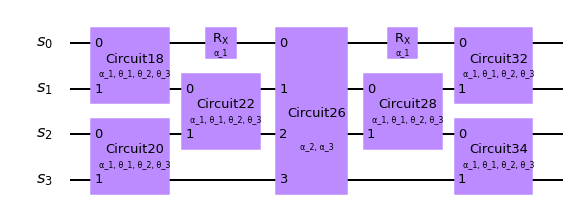

In [8]:
## Define spin chain
spinChain = QuantumRegister(4,name='s')
## Create quantum register
qc_DemoEvol = QuantumCircuit(spinChain)
## Append ST step
qc_DemoEvol.append(SuzukiTrotter(spinChain),spinChain)
## Make circuit explicit
qc_DemoEvol = qc_DemoEvol.decompose()
## Draw circuit
qc_DemoEvol.draw(output='mpl')

## Time Simulation

After seeing that the simulation stages are put as expected, I set out to simulating a finite time simulation. To this end, I create a custom gate from a Quantum Circuit. I execute several circuits, with the simulator, and soter probability densities. Tried simulating a 2 spin system, and took a while, but not that much.

In [25]:
def TimeEvol(num_spins=2,steps=20,t=5,J=[1,1,1],h=[0,0,0]):
    ## Perform Time simulation for
    ## num_spins spins in a chain
    ## a total time t
    ## using steps ST blocks
    ## With J and h as parameters for Hamiltonian
    #######################################################
    ## Definition of parameters for ST step
    dt = t/steps;
    th1 = J[0]*dt/2; th2 = J[1]*dt/2; th3 = J[2]*dt/2;
    a1 = h[0]*dt/2; a2 = h[1]*dt/2; a3 = h[2]*dt;
    ## Dictionary of parameters for binding
    params = {
        theta_1:th1,
        theta_2:th2,
        theta_3:th3,
        alpha1:a1,
        alpha2:a2,
        alpha3:a3,
    }
    ## Create quantum registers with expected size
    spinChain = QuantumRegister(num_spins,name='s')
    measureReg = ClassicalRegister(num_spins,name='b')
    ## Create list with quantum circuits to simulate
    Circuits = [QuantumCircuit(spinChain,measureReg) for _ in range(steps)]
    ## Append ST steps to each circuit
    for idx in range(steps):
        for _ in range(idx+1):
            Circuits[idx].append(SuzukiTrotter(spinChain),spinChain)
        Circuits[idx].measure(spinChain,measureReg)
        Circuits[idx] = Circuits[idx].bind_parameters(params)
    ## Simulate and store counts for each circuit simulation
    SimulResults = [execute(circuit,backend,shots=2048).result().get_counts() for circuit in Circuits]
    ## Acomodate simulation results to reflect PD
    PD = [[res.get("{0:b}".format(num).zfill(num_spins),0) for res in SimulResults] for num in range(2**num_spins)]
    return PD

In the next cell I simulate a pair of spins in the presencence of a non trivial magnetic field.

In [ ]:
SimulRes = TimeEvol(steps=400,t=5,h=[0,0,0])

Then, I plot the probability density that corresponds to measurement in the computational basis. I can appreciate very nice spin precessions.

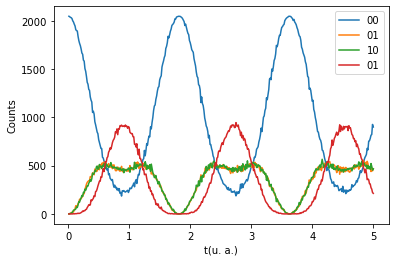

In [46]:
import matplotlib.pyplot as plt

trange = [(idx + 1)*5/400 for idx in range(400)]
plt.xlabel(r't(u. a.)')
plt.ylabel(r'Counts')
plt.plot(trange,SimulRes[0],label='00')
plt.plot(trange,SimulRes[1],label='01')
plt.plot(trange,SimulRes[2],label='10')
plt.plot(trange,SimulRes[3],label='01')
plt.legend()
plt.show()